# Train and Evaluate Deep Learning Models for MIMIC Dataset

In [ ]:
from importlib import resources as impresources
import os

import torch

from recurrent_health_events_prediction.utils.general_utils import import_yaml_config
from recurrent_health_events_prediction import configs

data_config = import_yaml_config(
    impresources.files(configs) / "data_config.yaml"
)

training_data_config = data_config['training_data']["mimic"]
data_directory = training_data_config['data_directory']

OVERWRITE_PREPROCESSED = False

In [2]:
print("Train and test data directory:", data_directory)

Train and test data directory: /workspaces/msc-thesis-recurrent-health-modeling/data/mimic-iii-preprocessed/copd_hf_renal_diabetes/multiple_hosp_patients/train_test


In [3]:
model_name = "gru_duration_aware_min"
model_config_path =f"/workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/{model_name}/{model_name}_config.yaml"
 
model_config = import_yaml_config(model_config_path)
for key, value in model_config.items():
    print(f"{key}: {value}")

model_params_dict = model_config['model_params']
assert model_params_dict['input_size_curr'] == len(model_config['current_feat_cols'])
assert model_params_dict['input_size_seq'] == len(model_config['longitudinal_feat_cols'])

model_name: GRU Duration Aware Minimal
batch_size: 64
num_epochs: 100
learning_rate: 0.01
model_class: GRUNet
longitudinal_feat_cols: ['LOG_DAYS_IN_ICU', 'CHARLSON_INDEX', 'DISCHARGE_LOCATION_POST_ACUTE_CARE', 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION']
current_feat_cols: ['LOG_DAYS_IN_ICU', 'CHARLSON_INDEX', 'LOG_NUM_DRUGS', 'NUM_PROCEDURES', 'DISCHARGE_LOCATION_POST_ACUTE_CARE', 'LOG_PARTICIPATION_DAYS', 'AGE', 'GENDER_M', 'ADMISSION_TYPE_ELECTIVE', 'ETHNICITY_WHITE']
max_sequence_length: 4
no_elective: True
reverse_chronological_order: False
model_params: {'input_size_curr': 10, 'hidden_size_head': 32, 'input_size_seq': 4, 'hidden_size_seq': 16, 'num_layers_seq': 1, 'dropout': 0.1}


In [4]:
save_results_dir = os.path.dirname(model_config_path) + "/multiple_hosp_patients"
print("Model results will be saved to:", save_results_dir)

Model results will be saved to: /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/gru_duration_aware_min/multiple_hosp_patients


In [5]:
# Prepare datasets (load existing or create + save new)
from recurrent_health_events_prediction.training.train_deep_learning_models import prepare_train_test_datasets


train_dataset, test_dataset, last_events_test_dataset, train_df_path, test_df_path = prepare_train_test_datasets(
    data_directory=data_directory,
    training_data_config=training_data_config,
    model_config=model_config,
    save_output_dir_path=save_results_dir,
    save_scaler_dir_path=None,
    overwrite_preprocessed=OVERWRITE_PREPROCESSED,
)

Preparing train and test datasets...
Creating new PyTorch datasets...
Test dataset (all events) size: 1085
Test dataset (last events only) size: 353
Saved PyTorch datasets to /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/gru_duration_aware_min/multiple_hosp_patients


## Inspect Train Data

In [6]:
import pandas as pd

train_df = pd.read_csv(train_df_path)

train_df[model_config['current_feat_cols']].describe()

,LOG_DAYS_IN_ICU,CHARLSON_INDEX,LOG_NUM_DRUGS,NUM_PROCEDURES,LOG_PARTICIPATION_DAYS,AGE
count,4.792000e+03,4.792000e+03,4.792000e+03,4.792000e+03,4792.000000,4.792000e+03
mean,-1.542079e-16,-1.542079e-16,-2.965537e-17,8.896612e-17,0.000000,3.410368e-17
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104,1.000104e+00
min,-1.776959e+00,-1.986906e+00,-2.987183e+00,-1.049072e+00,-1.941365,-2.623989e+00
25%,-7.121231e-01,-7.857893e-01,-6.958393e-02,-7.709598e-01,-0.941402,-6.492785e-01
50%,-1.927152e-01,1.495548e-02,2.501776e-01,-2.147359e-01,0.148044,9.123818e-02
75%,4.891051e-01,8.157002e-01,5.276853e-01,3.414881e-01,0.903392,7.700451e-01
max,4.729545e+00,4.018679e+00,1.594263e+00,5.347504e+00,1.626968,1.757401e+00


In [7]:
train_df[model_config["longitudinal_feat_cols"]].describe()

,LOG_DAYS_IN_ICU,CHARLSON_INDEX,LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION
count,4.792000e+03,4.792000e+03,4.792000e+03
mean,-1.542079e-16,-1.542079e-16,-3.558645e-17
std,1.000104e+00,1.000104e+00,1.000104e+00
min,-1.776959e+00,-1.986906e+00,-2.341308e+00
25%,-7.121231e-01,-7.857893e-01,-7.434079e-01
50%,-1.927152e-01,1.495548e-02,5.707672e-02
75%,4.891051e-01,8.157002e-01,8.074353e-01
max,4.729545e+00,4.018679e+00,2.081791e+00


In [8]:
test_df = pd.read_csv(test_df_path)

test_df[model_config['current_feat_cols']].describe()

,LOG_DAYS_IN_ICU,CHARLSON_INDEX,LOG_NUM_DRUGS,NUM_PROCEDURES,LOG_PARTICIPATION_DAYS,AGE
count,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000,1159.000000
mean,0.039402,0.002865,0.004981,-0.011491,-0.049707,0.102313
std,1.008152,0.995275,1.004078,0.996198,0.993121,0.951231
min,-1.776959,-1.986906,-2.987183,-1.049072,-1.941365,-2.623989
25%,-0.700478,-0.785789,-0.069584,-0.770960,-0.999885,-0.525859
50%,-0.175213,0.014955,0.250178,-0.214736,0.056942,0.214658
75%,0.573555,0.415328,0.527685,0.341488,0.854676,0.893465
max,3.629250,4.018679,1.438056,5.347504,1.559036,1.695691


### Create PyTorch Datasets

In [9]:
print("Output directory for model results:", save_results_dir)

Output directory for model results: /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/gru_duration_aware_min/multiple_hosp_patients


## Train the Model

In [10]:
from recurrent_health_events_prediction.training.train_deep_learning_models import train
from recurrent_health_events_prediction.model.RecurrentHealthEventsDL import GRUNet

model, loss_epochs = train(
    train_dataset=train_dataset,
    model_config=model_config,
    ModelClass=GRUNet
)


Using provided model class: GRUNet

Model initialized and ready for training.
Model parameters:
  input_size_curr: 10
  hidden_size_head: 32
  input_size_seq: 4
  hidden_size_seq: 16
  num_layers_seq: 1
  dropout: 0.1

Starting training...
Number of training samples: 4434
Batch size: 64
Learning rate: 0.01
Optimizer: Adam
Loss function: BCEWithLogitsLoss

Epoch 1/100, Loss: 0.5740983013595854
Epoch 2/100, Loss: 0.5565393779958997
Epoch 3/100, Loss: 0.552387033190046
Epoch 4/100, Loss: 0.5506070826734816
Epoch 5/100, Loss: 0.5499934758458819
Epoch 6/100, Loss: 0.5460280350276402
Epoch 7/100, Loss: 0.5448526054620743
Epoch 8/100, Loss: 0.5364257897649493
Epoch 9/100, Loss: 0.5342697752373559
Epoch 10/100, Loss: 0.5311442932912281
Epoch 11/100, Loss: 0.5241317693676267
Epoch 12/100, Loss: 0.5180675395897456
Epoch 13/100, Loss: 0.516165384224483
Epoch 14/100, Loss: 0.5145107580082757
Epoch 15/100, Loss: 0.5047499882323402
Epoch 16/100, Loss: 0.5021996987717492
Epoch 17/100, Loss: 0.501798

In [20]:
import plotly.graph_objects as go

batch_size = model_config['batch_size']
num_samples = len(train_dataset)

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=loss_epochs,
    x=list(range(1, len(loss_epochs) + 1)),
    mode='lines+markers',
    name='Training Loss'
))
fig.update_layout(
    title=f"Training Loss per Epoch (Batch size: {batch_size}, Train samples: {num_samples})",
    xaxis_title="Epoch",
    yaxis_title="Loss",
    template="plotly_white"
)
fig.write_html(os.path.join(save_results_dir, "training_loss.html"))
fig.show()

In [21]:
import torch

model_save_path = os.path.join(save_results_dir, f"{model_name}.pt")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /workspaces/msc-thesis-recurrent-health-modeling/_models/mimic/deep_learning/gru_duration_aware_min/multiple_hosp_patients/gru_duration_aware_min.pt


## Load Model

In [22]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsDL import GRUNet

model_save_path = os.path.join(save_results_dir, f"{model_name}.pt")
model = GRUNet(**model_params_dict)
model.load_state_dict(torch.load(model_save_path))
model.eval()

GRUNet(
  (gru): GRU(4, 16, batch_first=True)
  (classifier_head): Sequential(
    (fc1): Linear(in_features=26, out_features=32, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=32, out_features=1, bias=True)
  )
)

## Evaluate the Model

## Train Set

In [29]:
from recurrent_health_events_prediction.training.train_deep_learning_models import evaluate

test_metrics, all_pred_labels, all_pred_probs, all_labels = evaluate(
    model=model,
    test_dataset=train_dataset,
    batch_size=32
)
for key, value in test_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

Starting evaluation...
Number of test samples: 4434
Batch size: 32

f1_score: 0.7418
auroc: 0.9210
best_threshold: 0.2973
confusion_matrix: [[2870  396]
 [ 246  922]]
recall: 0.7894
accuracy: 0.8552
precision: 0.6995


### Test Set Evaluation

#### All Events

In [30]:
from recurrent_health_events_prediction.training.train_deep_learning_models import evaluate

test_metrics, all_pred_labels, all_pred_probs, all_labels = evaluate(
    model=model,
    test_dataset=test_dataset,
    batch_size=32
)
for key, value in test_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

Starting evaluation...
Number of test samples: 1085
Batch size: 32

f1_score: 0.3905
auroc: 0.5422
best_threshold: 0.1211
confusion_matrix: [[409 397]
 [115 164]]
recall: 0.5878
accuracy: 0.5281
precision: 0.2923


#### Last Events

In [31]:
test_metrics_last_events, all_pred_labels, all_pred_probs, all_labels = evaluate(
    model=model,
    test_dataset=last_events_test_dataset,
    batch_size=32
)
for key, value in test_metrics_last_events.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

Starting evaluation...
Number of test samples: 353
Batch size: 32

f1_score: 0.4089
auroc: 0.5576
best_threshold: 0.1062
confusion_matrix: [[139 123]
 [ 36  55]]
recall: 0.6044
accuracy: 0.5496
precision: 0.3090


In [26]:
test_pred_df = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_pred_labels,
    "pred_prob": all_pred_probs
})

test_pred_df.to_csv(os.path.join(save_results_dir, "test_predictions.csv"), index=False)

In [27]:
from recurrent_health_events_prediction.training.utils import plot_pred_proba_distribution

plot_pred_proba_distribution(test_pred_df["true_label"], test_pred_df["pred_prob"], show_plot=False)

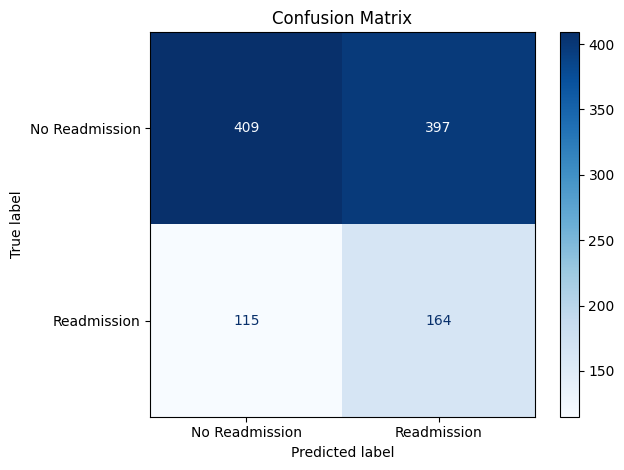

In [28]:
from recurrent_health_events_prediction.training.utils import plot_confusion_matrix

class_names=training_data_config["class_names"]
plot_confusion_matrix(test_metrics["confusion_matrix"], class_names)